# MOOCCubeX 03 - Dataset creation
- Categorize Fields into Harvard categories
- Embeddings
    1. Convert Embeddings from dim 300 to 100 by building fasttext from source
    2. Add embeddings to rows
- Listify and split into datasets


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import dask.dataframe as dd

In [2]:
sample_path = Path("mooc_cube_x-100k")
mooc_path = Path("~/fall_project/MOOCCubeX")
relations_path = mooc_path / "relations"

In [3]:
ITEM_COL = "video_id"
USER_COL = "user_id"
TIME_COL = "local_start_time"
SESSION_COL = "session_id"
CONSECUTIVE_COL = "item_consecutive_id"

### Categorize according to Harvard

In [4]:
%%time
#TODO: Update path to "sessions_featured_fix" for re-run
sessions_df = dd.read_parquet(relations_path / "sessions_featured").drop(columns=["start", "end", "speed", "local_end_time", "forward_gap", "duration"]).compute()
sessions_df

CPU times: user 5.84 s, sys: 1.33 s, total: 7.17 s
Wall time: 7.52 s


time_spent  num_forward  \
user_id   item_consecutive_id session_id                            
U_1002389 1                   0                395.0          1.0   
          2                   0                419.0          2.0   
          3                   0                315.0          0.0   
U_1002476 1                   0                 71.0          0.0   
          2                   0                275.2          1.0   
...                                              ...          ...   
U_99746   1                   1                280.0          2.0   
          2                   0                378.8          8.0   
          3                   0                536.4          4.0   
          4                   0                324.8          1.0   
          5                   0                 25.0          0.0   

                                          num_backward  num_pause  \
user_id   item_consecutive_id session_id                            
U_1002389 1                   0                    0.0        1.0   
          2                   0                    0.0        2.0   
          3                   0                    0.0        0.0   
U_1002476 1                   0                    0.0        0.0   
          2                   0                    0.0        1.0   
...                                                ...        ...   
U_99746   1                   1                    0.0        2.0   
          2                   0                    0.0        8.0   
          3                   0                    0.0        4.0   
          4                   0                    0.0        1.0   
          5                   0                    0.0        0.0   

                                          median_pause  std_speed  avg_speed  \
user_id   item_consecutive_id session_id                                       
U_1002389 1                   0                    6.0        0.0       1.00   
          2                   0                    6.0        0.0       1.00   
          3                   0                    NaN        NaN       1.00   
U_1002476 1                   0                    NaN        NaN       1.00   
          2                   0                  148.0        0.0       1.00   
...                                                ...        ...        ...   
U_99746   1                   1                   54.6        0.0       1.25   
          2                   0                    4.8        0.0       1.25   
          3                   0                   37.4        0.0       1.25   
          4                   0                  279.6        0.0       1.25   
          5                   0                    NaN        NaN       1.25   

                                          eff_speed  seg_rep_0  seg_rep_1  \
user_id   item_consecutive_id session_id                                    
U_1002389 1                   0                 0.0        0.0        0.0   
          2                   0                 0.0        0.0        0.0   
          3                   0                 0.0        0.0        0.0   
U_1002476 1                   0                 0.0        0.0        0.0   
          2                   0                 0.0        0.0        0.0   
...                                             ...        ...        ...   
U_99746   1                   1                 0.0        0.0        0.0   
          2                   0                 0.0        0.0        0.0   
          3                   0                 0.0        0.0        0.0   
          4                   0                 0.0        0.0        0.0   
          5                   0                 0.0        0.0        0.0   

                                          ...  replay_length  skipped_length  \
user_id   item_consecutive_id session_id  ...                                  
U_1002389 1                   0           .

### With transformers
Using Helsinki at commit 820b01075a2e1c1f575e83c1ecc9d43d589195e8

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

In [ ]:
en2cn = pipeline("translation", model="Helsinki-NLP/opus-mt-zh-en", device=-1)

In [ ]:
fields[:2]

In [ ]:
hf_en_fields = en2cn(fields)
hf_cn2en_fields = dict(zip(fields, [field["translation_text"] for field in hf_en_fields]))
hf_cn2en_fields

In [ ]:
cn2en_fields_df = pd.DataFrame(hf_cn2en_fields.items(), columns=["cn", "en"])
cn2en_fields_df

In [ ]:
cn2en_fields_df.to_csv("fields_cn2en.csv")

### Embedding fields and concepts - MOOC Specific
* Must aggregate concepts and fields -> Simple per-dim average
* Some fields might be the same -> Must use the set first
* **Currently** - `not-field` fields are embedded the same way as regular fields

In [10]:
import fasttext

In [11]:
emb_table = fasttext.load_model("cc.zh.64.bin")

`print-sentence-vectors` do not provide the given sentence -> THe order is given by the lines above

### Create embedding tables
Have to use the encoded strings as integer lookups in a manually created lookup table

In [7]:
%%time
unique_concepts = sessions_df["concept_id"].explode().dropna().unique()
fields = list(set([con_id.split("_")[-1].strip() for con_id in unique_concepts if con_id]))
concepts = list(set(["_".join(con_id.split("_")[1:-1]).strip() for con_id in unique_concepts if con_id]))

CPU times: user 5.12 s, sys: 258 ms, total: 5.38 s
Wall time: 5.45 s


In [8]:
len(fields), len(concepts)

(74, 170807)

In [12]:
%%time
embedded_concepts = np.array([emb_table.get_sentence_vector(concept) for concept in concepts])
embedded_fields = np.array([emb_table.get_sentence_vector(field) for field in fields])

CPU times: user 1.19 s, sys: 18.8 ms, total: 1.21 s
Wall time: 1.24 s


In [13]:
# Create explicit mapping between feature and embedding
field2float = dict(zip(fields, embedded_fields))
concept2float = dict(zip(concepts, embedded_concepts))

#### Clustering of fields corresponding to category

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [15]:
import matplotlib.cm as cm

In [16]:
pca = PCA(n_components=2, svd_solver='full')
pca_fields = pca.fit_transform(embedded_fields)

In [18]:
tsne_fields = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(embedded_fields)

In [19]:
field2pca_df = pd.DataFrame.from_dict(dict(zip(fields, pca_fields)), orient="index").rename(columns={0:"pca_0", 1:"pca_1"})
field2tsne_df = pd.DataFrame.from_dict(dict(zip(fields, tsne_fields)), orient="index").rename(columns={0:"tsne_0", 1:"tsne_1"})
field_zh2en = pd.read_csv("fields_cn2en.csv", index_col=1).drop(columns="Unnamed: 0")
field2float_df = field2pca_df.merge(field2tsne_df, right_index=True, left_index=True).merge(field_zh2en[["category"]], left_index=True, right_index=True)
field2float_df

,pca_0,pca_1,tsne_0,tsne_1,category
社会学,0.600456,-0.020818,-24.349712,-13.739228,HHRDE
园艺学,0.472183,-0.058895,-11.162151,-13.777596,STEM
石油与天然气工程,-0.231096,0.193418,23.537630,30.877180,STEM
法学,0.580243,-0.004671,-22.774601,-15.836410,HHRDE
情报与档案管理,-0.456929,-0.387129,23.039135,-11.722817,CS
...,...,...,...,...,...
科学技术史,-0.480170,0.148493,26.651512,31.736624,HHRDE
信息与通信工程,-0.205643,-0.053678,21.835335,32.837288,CS
外国语言文学,-0.085789,0.173992,40.559753,5.539748,HHRDE
环境科学与工程,-0.627034,-0.258001,8.664123,14.366393,STEM


Text(0.5, 1.0, 'TSNE reduced')

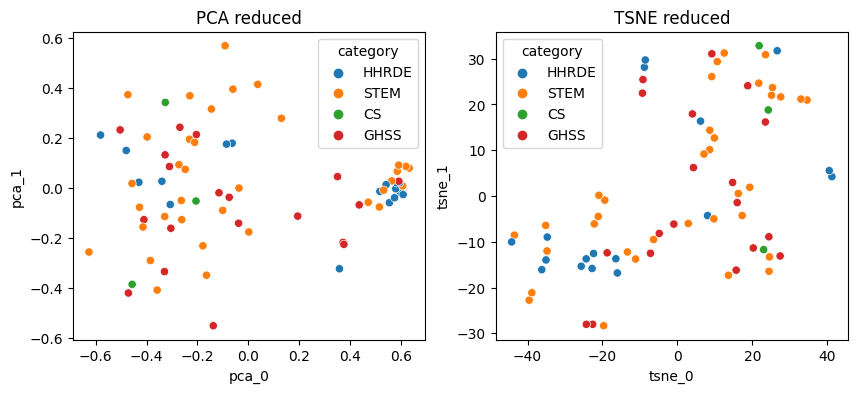

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
sns.scatterplot(field2float_df, x="pca_0", y="pca_1", hue="category", ax=axes[0]).set_title("PCA reduced")
sns.scatterplot(field2float_df, x="tsne_0", y="tsne_1", hue="category", ax=axes[1]).set_title("TSNE reduced")

### Cluster exploration for fields

For n_clusters = 2 The average silhouette_score is : 0.14666396
For n_clusters = 3 The average silhouette_score is : 0.12645853
For n_clusters = 4 The average silhouette_score is : 0.13889344
For n_clusters = 5 The average silhouette_score is : 0.1339763
For n_clusters = 6 The average silhouette_score is : 0.13515028
For n_clusters = 7 The average silhouette_score is : 0.12674336
For n_clusters = 8 The average silhouette_score is : 0.13284022
For n_clusters = 9 The average silhouette_score is : 0.13135162
For n_clusters = 10 The average silhouette_score is : 0.14329855


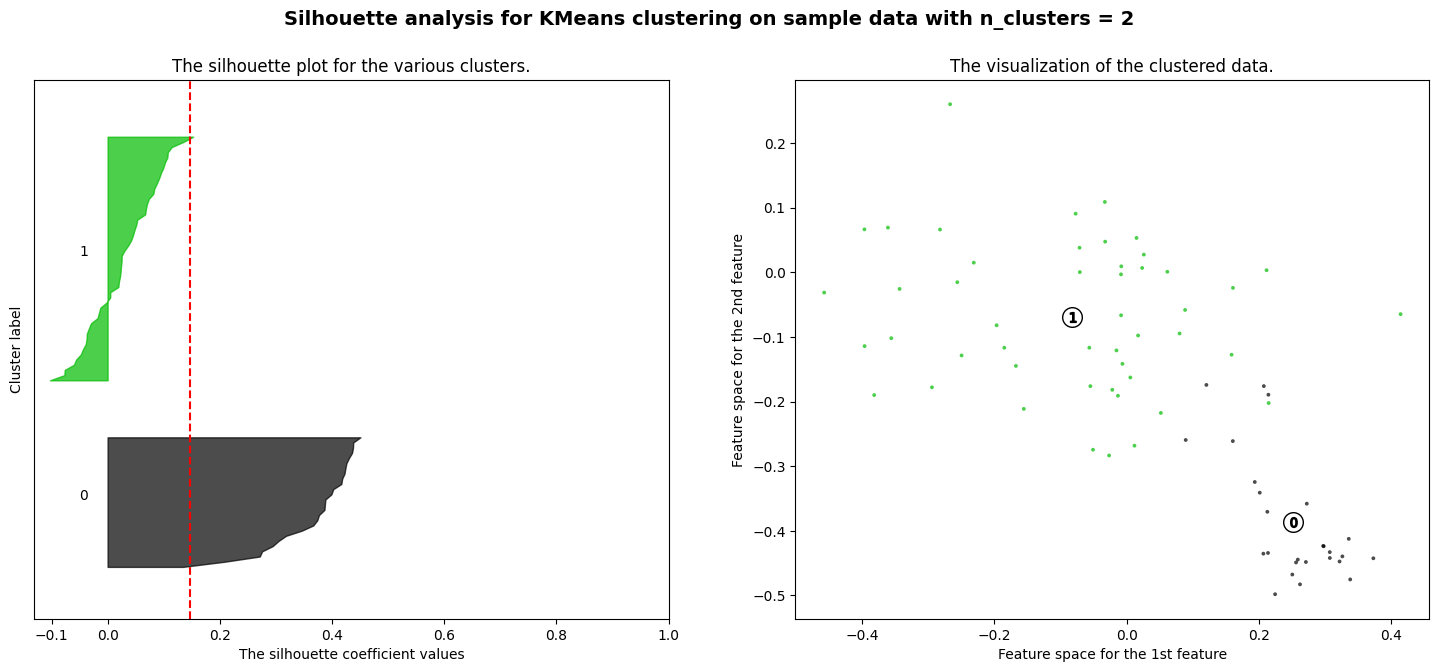

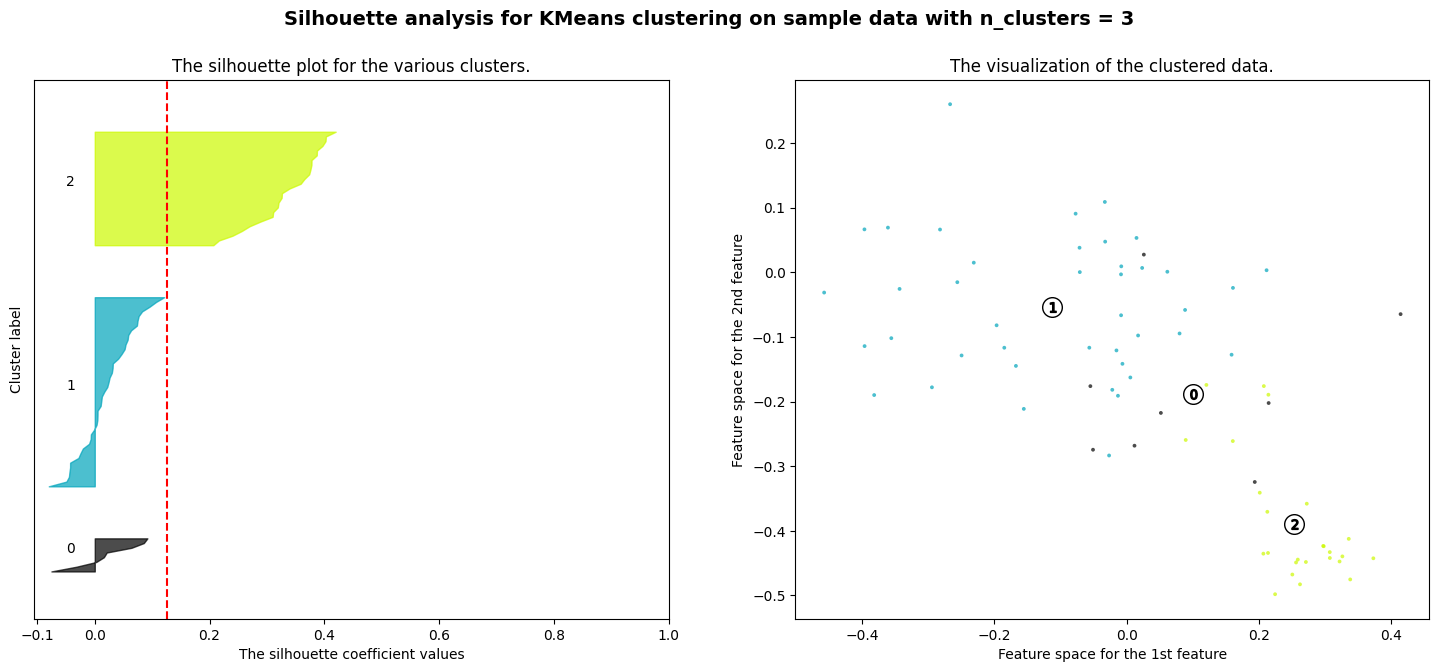

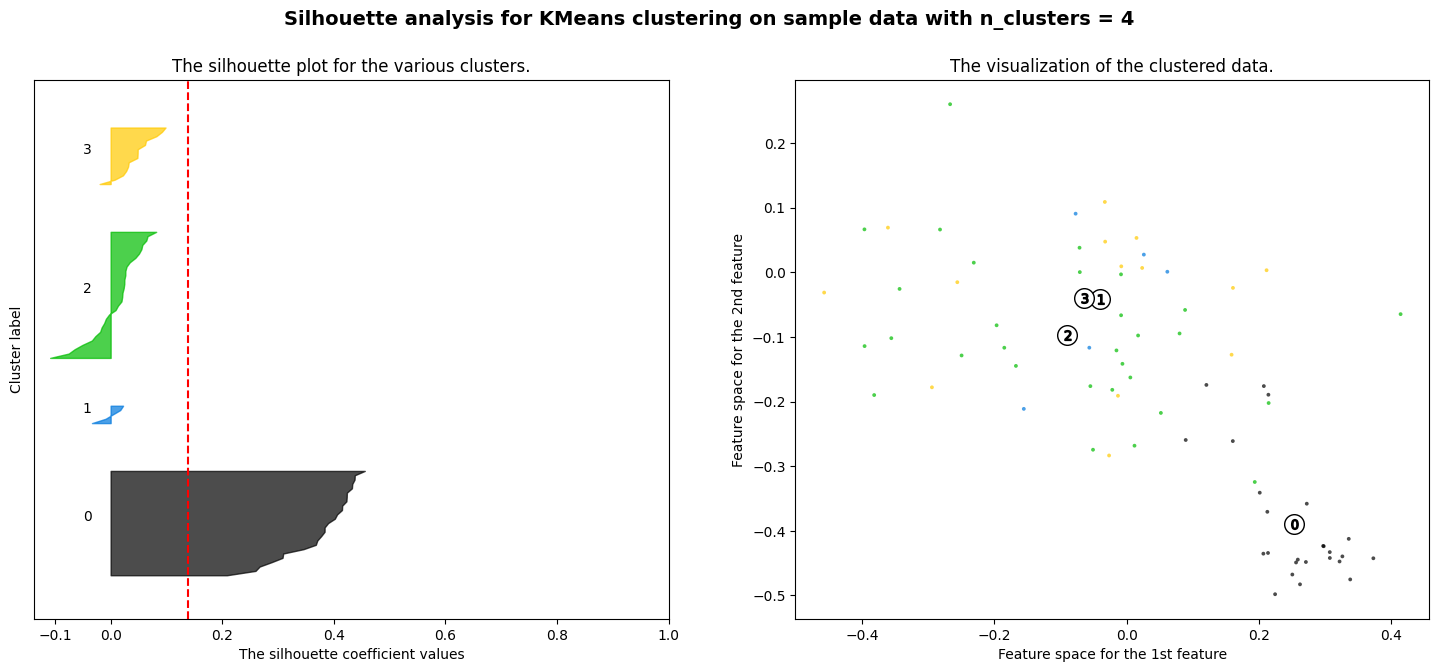

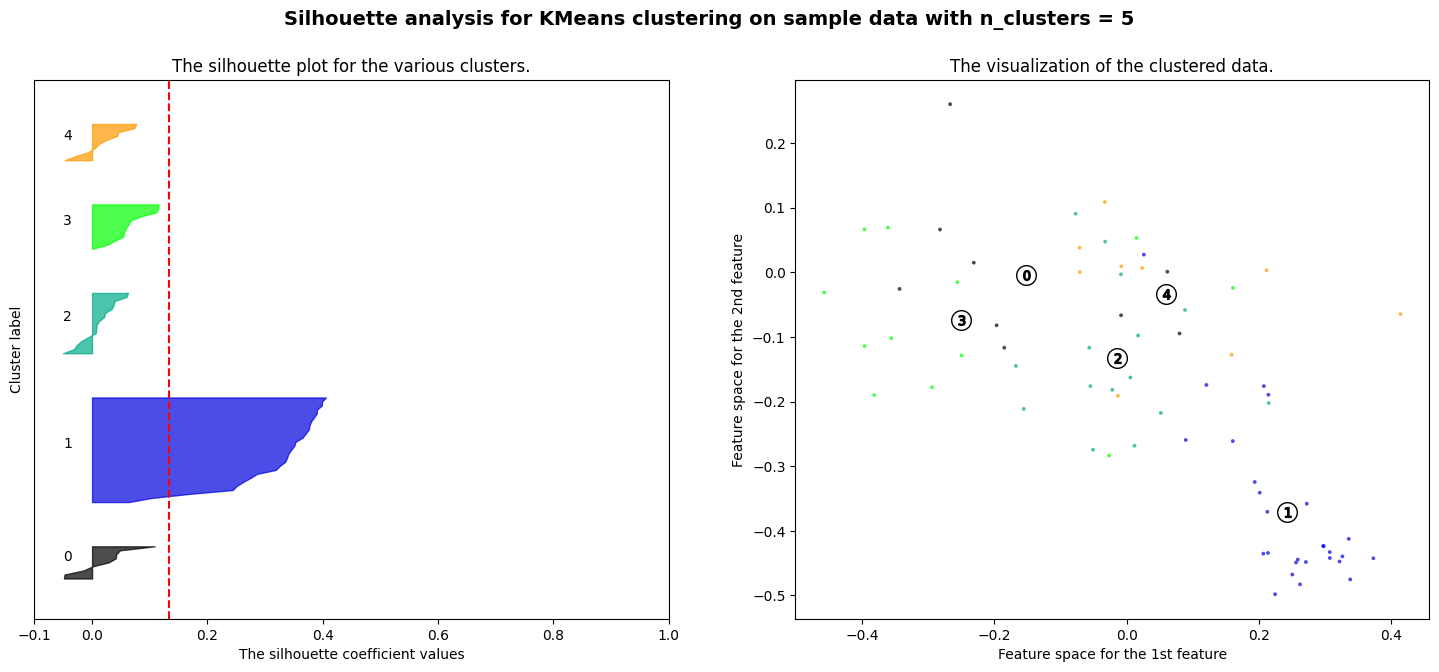

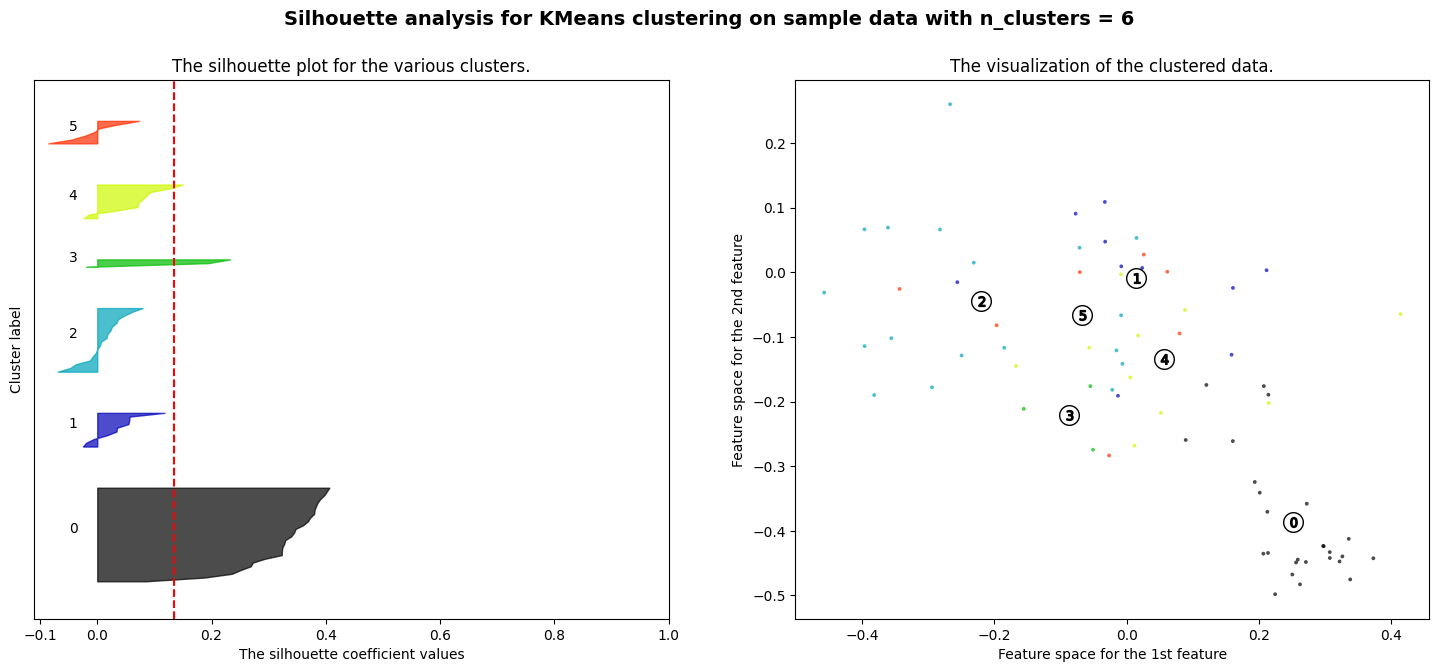

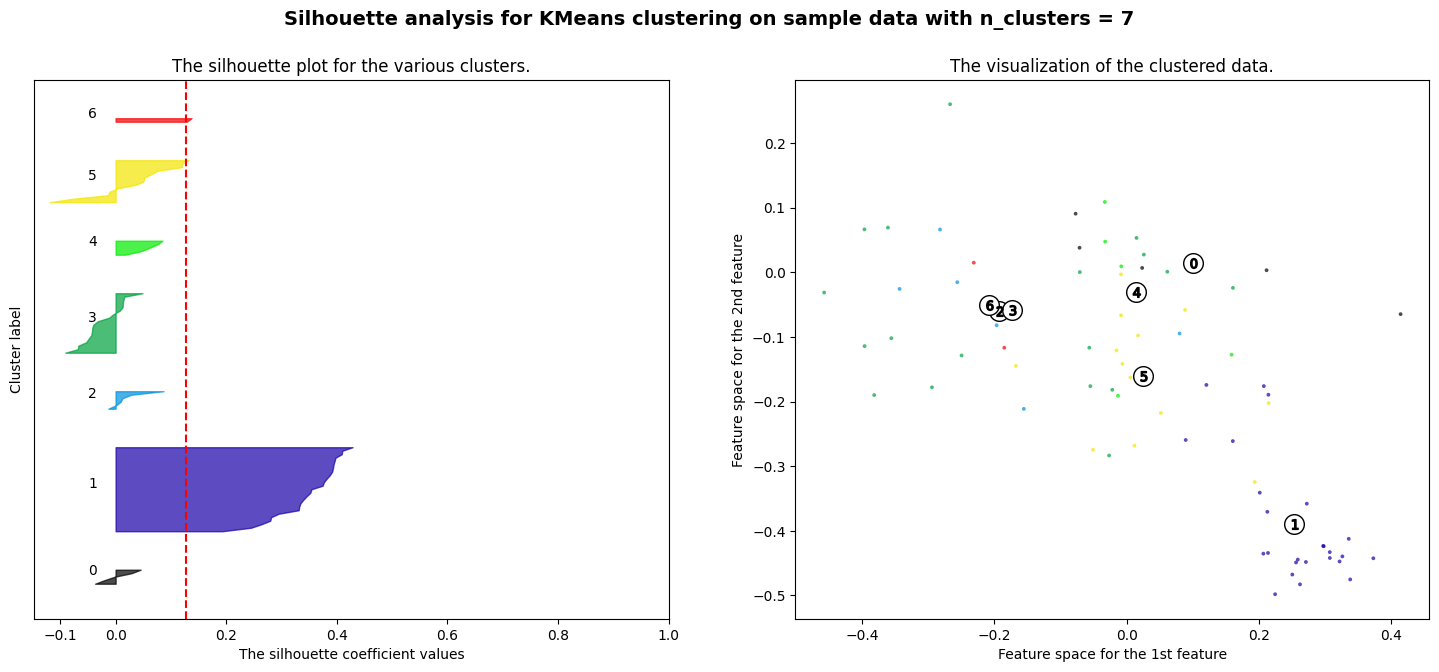

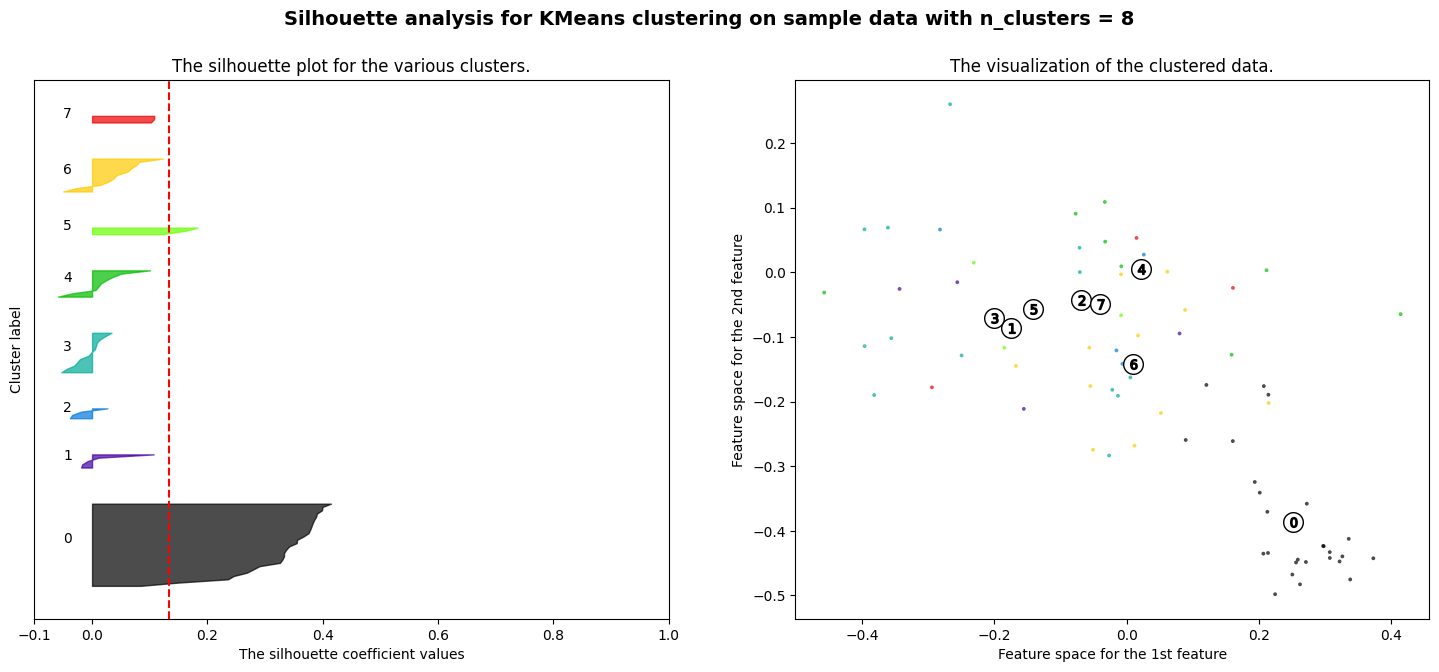

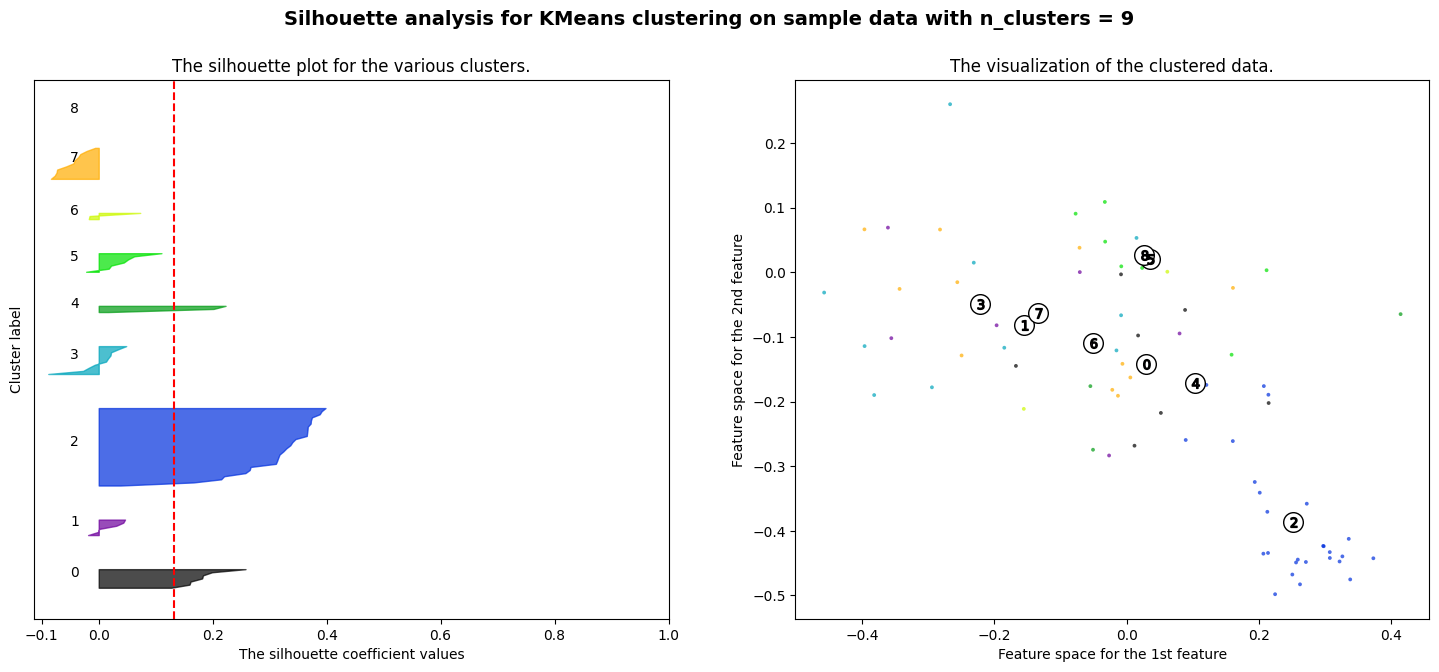

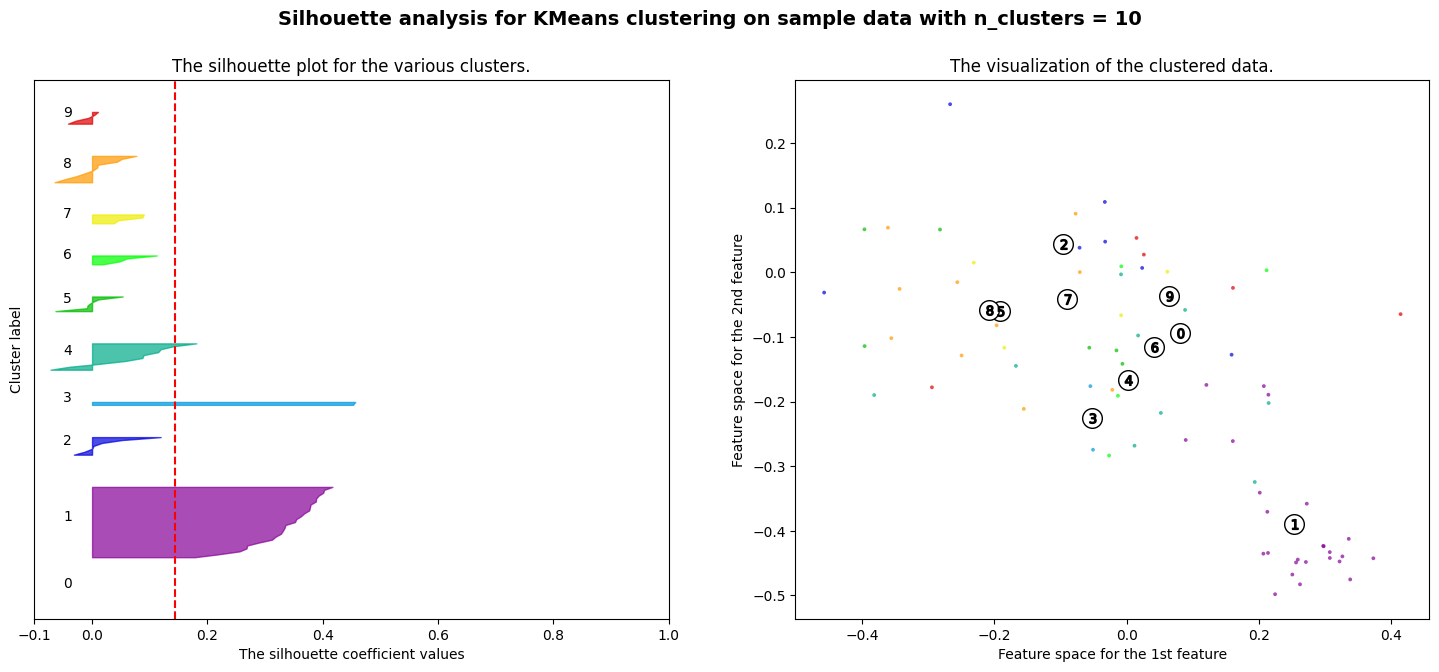

In [24]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    #ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(embedded_fields) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(embedded_fields)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(embedded_fields, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(embedded_fields, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        embedded_fields[:, 0], embedded_fields[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()